In [1]:
import json
import warnings
from typing import Any, Literal

import numpy as np
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)


# Demo (Prevents ruff from removing the unused module import)
name: Any
category: Literal["A", "B", "C"]
json.loads('{"name": "Smart-RAG", "version": "1.0"}')

{'name': 'Smart-RAG', 'version': '1.0'}

In [3]:
go_up_from_current_directory(go_up=1)

from src.config import app_settings  # noqa: E402
from src.utilities.model_config import RemoteModel  # noqa: E402

settings = app_settings

/Users/mac/Desktop/Projects/smart-rag


In [4]:
from langchain_openai import ChatOpenAI

remote_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.GEMINI_2_0_FLASH_001,
)


# Test the LLMs
response = remote_llm.invoke("Tell me a very short joke.")
response.pretty_print()

================================== Ai Message ==================================

Why don't scientists trust atoms?

Because they make up everything!


In [5]:
_doc_1: list[str] = [
    "Lionel Andrés Messi was born on June 24, 1987, in Rosario, Argentina, as the third of four children in a working-class family,",
    "with his father managing a steel factory and his mother working as a cleaner. Diagnosed with growth hormone deficiency",
    "at age 10, Messi faced financial challenges for treatment until FC Barcelona scouts spotted his talent and offered to,",
    "cover the costs, prompting his move to Spain at 13 to join the club's renowned La Masia academy. He made his ",
    "competitive debut for Barcelona in October 2004 at just 17 years old, quickly rising to become one of the greatest players ",
    "in history during his 17-season tenure, amassing numerous accolades including multiple Ballon d'Or awards, La Liga titles, ",
    "and UEFA Champions League triumphs while scoring over 670 goals for the club.",
    "After leaving Barcelona in 2021 due to financial constraints at the club, Messi signed with Paris Saint-Germain (PSG), where he spent two seasons, winning Ligue 1 titles and contributing significantly",
    "despite adapting to a new environment. In 2023, he joined Inter Miami CF in Major League Soccer, bringing global attention to the league and leading the team to victories like the Leagues Cup, while",
    "continuing to excel individually. On a personal note, Messi married his childhood sweetheart Antonela Roccuzzo in 2017, and the couple has three sons: Thiago, Mateo, and Ciro; he is also deeply, ",
    "involved in philanthropy through the Leo Messi Foundation, which supports children's health and education initiatives worldwide",
    "Cristiano Ronaldo is widely regarded as one of the greatest footballers in history, known for his extraordinary athleticism, goal-scoring consistency, and relentless drive for excellence. Rising from humble beginnings ",
    "in Madeira, he quickly became a global sensation through his performances at Sporting CP, Manchester United, Real Madrid, and later Juventus and the Portuguese national team. His career has been characterized by remarkable ",
    "adaptability—thriving in different leagues, systems, and roles—while maintaining elite performance levels for nearly two decades.",
    "Beyond his on-field achievements, Ronaldo is recognized for his professionalism, discipline, and influential global brand. He has inspired millions through his work ethic, ",
    "philanthropy, and commitment to pushing personal boundaries in fitness and performance. Whether breaking records, leading his teams to major trophies, ",
    "or serving as a role model to aspiring athletes, Ronaldo’s impact reaches far beyond football, solidifying his legacy as a global sports icon.",
]

_doc_messi: list[str] = [
    "Lionel Messi's international career with Argentina has been marked by remarkable achievements and records, transforming him from a prodigy to a ",
    "national hero. He made his senior debut in 2005 and has since become Argentina's all-time leading goalscorer with 115 goals in 196 appearances",
    "also holding the record for the most caps. Early successes include winning the 2005 FIFA U-20 World Cup and the 2008 Olympic gold medal. As captain, ",
    "he led Argentina to victories in the 2021 and 2024 Copa América tournaments, the 2022 Finalissima, and the crowning 2022 FIFA World Cup, where he ",
    "earned the Golden Ball with 7 goals and 3 assists, setting records for most World Cup appearances (26) and goal contributions (21). In 2023, he became ",
    "the third player to score 100 international goals, and by 2025, he achieved 60 assists, the most in men's international football history",
    "Throughout his career, Messi has amassed an unparalleled collection of awards and shattered numerous records. He has won eight Ballon d'Or awards",
    "(2009, 2010, 2011, 2012, 2015, 2019, 2021, 2023), six European Golden Shoes, and was named the IFFHS All-Time Men's World Best Player in 2025.",
    "His records include the most goals in a calendar year (91 in 2012), most goals for a single club (672 for Barcelona), and most in La Liga (474), ",
    "with over 890 senior career goals and 400 assists overall. Recent developments include winning the MLS Golden Boot in 2025 with 29 goals and 19 ",
    "assists for Inter Miami, extending his contract through 2028, and receiving the Presidential Medal of Freedom from U.S. President Joe Biden in 2025 for his philanthropic efforts.",
]

_doc_ronaldo: list[str] = [
    "Cristiano Ronaldo is widely regarded as one of the greatest footballers of all time, a testament to his unparalleled dedication, physical prowess, and a relentless goal-scoring instinct. ",
    "Rising from humble beginnings in Madeira, Portugal, he first captured the world's attention with his dazzling skills and trickery at Manchester United. It was there, however, that ",
    "he transformed from a showman into a ruthless, all-around attacker, winning his first Ballon d'Or and the UEFA Champions League. His subsequent move to Real Madrid cemented his ",
    "legendary status, where he became the club's all-time leading scorer, shattered numerous records, and won four more Ballons d'Or, solidifying a fierce and iconic rivalry with ",
    "Lionel Messi that defined a generation of football.",
    "Beyond his on-field statistics, Ronaldo's legacy is built on an almost superhuman work ethic ",
    "and a longevity that has allowed him to dominate at the highest level for nearly two decades. His leadership has been ",
    "instrumental for both club and country, culminating in his crowning achievement: captaining Portugal to victory at the UEFA Euro 2016. ",
    "A global phenomenon, his influence extends far beyond the pitch through his immense social media presence and the CR7 brand, making him one of ",
    "the most recognizable and marketable athletes in history. More than just a player, Ronaldo is an icon of discipline, ambition, and the relentless pursuit of perfection.",
]

In [ ]:
import asyncio

from langchain_core.documents.base import Document
from sentence_transformers import CrossEncoder

reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")


def rerank_documents(
    query: str, documents: list[Document], k: int = 3
) -> list[Document]:
    """Rerank documents by relevance to query using CrossEncoder.

    Parameters
    ----------
    query : str
        The search query string.
    documents : list[Document]
        List of Document objects to rerank.
    k : int, optional
        Maximum number of documents to return, by default 3.

    Returns
    -------
    list[Document]
        Documents sorted by relevance score in descending order.
    """
    # Prepare pairs of (query, document content) for scoring
    pairs: list[tuple[str, str]] = [(query, doc.page_content) for doc in documents]
    # Get relevance scores from the CrossEncoder
    scores: list[float] | np.ndarray = reranker.predict(pairs)

    # Combine documents with their scores
    doc_score_pairs: list[tuple[Document, float]] = list(zip(documents, scores))
    # Sort documents by score in descending order
    ranked_docs: list[Document] = [
        doc for doc, _ in sorted(doc_score_pairs, key=lambda x: x[1], reverse=True)
    ][:k]
    return ranked_docs


async def arerank_documents(
    query: str, documents: list[Document], k: int = 3
) -> list[Document]:
    """Asynchronously rerank documents by relevance to query using CrossEncoder.

    Parameters
    ----------
    query : str
        The search query string.
    documents : list[Document]
        List of Document objects to rerank.
    k : int, optional
        Maximum number of documents to return, by default 3.

    Returns
    -------
    list[Document]
        Documents sorted by relevance score in descending order.
    """
    return await asyncio.to_thread(rerank_documents, query, documents, k)

In [ ]:
from uuid import uuid4

from langchain_core.documents.base import Document

web_docs_messi = [
    Document(
        page_content=content, metadata={"source": f"https://example.com/doc_messi/{i}"}
    )
    for i, content in enumerate(_doc_messi)
]
web_docs_ronaldo = [
    Document(
        page_content=content,
        metadata={"source": f"https://example.com/doc_ronaldo/{i}"},
    )
    for i, content in enumerate(_doc_ronaldo)
]
internal_docs = [
    Document(
        page_content=content,
        metadata={"chunk_id": str(uuid4()), "source": "internal_doc_1"},
    )
    for content in _doc_1
]


async def aweb_search(
    query: str = "",  # noqa: ARG001
    fetch_full_page: bool = False,  # noqa: ARG001
    k: int = 5,
    max_chars: int | None = None,  # noqa: ARG001
) -> list[Document]:
    """Asynchronously retrieve web documents.

    Returns:
    --------
    list[Document]
        A list of Document objects representing the web documents.
    """
    rng = np.random.default_rng(seed=42)
    if "messi" in query.lower():
        return rng.choice(web_docs_messi, k, replace=False).tolist()
    return rng.choice(web_docs_ronaldo, k, replace=False).tolist()

In [8]:
await aweb_search(query="Tell me about Lionel Messi", k=3)

[Document(metadata={'source': 'https://example.com/doc_messi/10'}, page_content='assists for Inter Miami, extending his contract through 2028, and receiving the Presidential Medal of Freedom from U.S. President Joe Biden in 2025 for his philanthropic efforts.'),
 Document(metadata={'source': 'https://example.com/doc_messi/0'}, page_content="Lionel Messi's international career with Argentina has been marked by remarkable achievements and records, transforming him from a prodigy to a "),
 Document(metadata={'source': 'https://example.com/doc_messi/7'}, page_content="(2009, 2010, 2011, 2012, 2015, 2019, 2021, 2023), six European Golden Shoes, and was named the IFFHS All-Time Men's World Best Player in 2025.")]

In [9]:
await aweb_search(query="Tell me about C Ronaldo", k=3)

[Document(metadata={'source': 'https://example.com/doc_ronaldo/9'}, page_content='the most recognizable and marketable athletes in history. More than just a player, Ronaldo is an icon of discipline, ambition, and the relentless pursuit of perfection.'),
 Document(metadata={'source': 'https://example.com/doc_ronaldo/0'}, page_content='Cristiano Ronaldo is widely regarded as one of the greatest footballers of all time, a testament to his unparalleled dedication, physical prowess, and a relentless goal-scoring instinct. '),
 Document(metadata={'source': 'https://example.com/doc_ronaldo/6'}, page_content='and a longevity that has allowed him to dominate at the highest level for nearly two decades. His leadership has been ')]

In [10]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams

from src.utilities.embeddings import OpenRouterEmbeddings
from src.utilities.utils import (
    convert_langchain_messages_to_dicts,
    get_structured_output,
)

client = QdrantClient(":memory:")
embeddings = OpenRouterEmbeddings()

vector_size: int = len(await embeddings.aembed_query("sample text"))
collection_name: str = "smart_rag_collection"

if not client.collection_exists(collection_name):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE),
    )
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings,
)
# Embed all the documents
document_ids: list[str] = await vectorstore.aadd_documents(documents=internal_docs)
print(document_ids[:3])

['55c7664ff656419c827460bbe7038264', 'a94e63847dd2468e94f49901f2131036', '59615189a6bd4090bd79f3ec9aaa2f1e']


In [12]:
async def aretrieve_internal_documents(
    query: str,  # noqa: ARG001
    fetch_full_page: bool = False,  # noqa: ARG001
    k: int = 5,
    max_chars: int | None = None,  # noqa: ARG001
) -> list[Document]:
    """Asynchronously retrieve internal documents.

    Returns:
    --------
    list[Document]
        A list of Document objects representing the internal documents.
    """
    return await vectorstore.asimilarity_search(query, k=k)

In [13]:
await aretrieve_internal_documents(query="Tell me about Lionel Messi", k=3)

[Document(metadata={'chunk_id': 'a061167d-8ea8-4ddd-a549-22d97068515d', 'source': 'internal_doc_1', '_id': '55c7664ff656419c827460bbe7038264', '_collection_name': 'smart_rag_collection'}, page_content='Lionel Andrés Messi was born on June 24, 1987, in Rosario, Argentina, as the third of four children in a working-class family,'),
 Document(metadata={'chunk_id': '81ff2948-9231-468e-96b3-085543986e27', 'source': 'internal_doc_1', '_id': 'c6f5d0c8f76b4ed3a2bc54a483d3bb89', '_collection_name': 'smart_rag_collection'}, page_content='continuing to excel individually. On a personal note, Messi married his childhood sweetheart Antonela Roccuzzo in 2017, and the couple has three sons: Thiago, Mateo, and Ciro; he is also deeply, '),
 Document(metadata={'chunk_id': '113968a9-931b-4128-983e-e8470a5cdf9b', 'source': 'internal_doc_1', '_id': 'ab5d1ad7292f4bd58df3c22de31231a4', '_collection_name': 'smart_rag_collection'}, page_content="involved in philanthropy through the Leo Messi Foundation, which 

In [14]:
await aretrieve_internal_documents(query="Tell me about C Ronaldo", k=3)

[Document(metadata={'chunk_id': 'e4bcd5a3-a7d6-4516-9c12-5da23e10e831', 'source': 'internal_doc_1', '_id': '895851d24e484294bdb4db7859a2cbcf', '_collection_name': 'smart_rag_collection'}, page_content='Cristiano Ronaldo is widely regarded as one of the greatest footballers in history, known for his extraordinary athleticism, goal-scoring consistency, and relentless drive for excellence. Rising from humble beginnings '),
 Document(metadata={'chunk_id': 'a1a12c8b-ffed-4a6f-a5dd-ef4312611125', 'source': 'internal_doc_1', '_id': 'd436bda79def46679c92d4d0e105224a', '_collection_name': 'smart_rag_collection'}, page_content='Beyond his on-field achievements, Ronaldo is recognized for his professionalism, discipline, and influential global brand. He has inspired millions through his work ethic, '),
 Document(metadata={'chunk_id': '85adf287-3779-467a-baea-f6d925441099', 'source': 'internal_doc_1', '_id': '5c899e443ec147bc85408233a38948ac', '_collection_name': 'smart_rag_collection'}, page_conte

In [40]:
validation_prompt: str = """
<SYSTEM>
    <ROLE>Expert at determining if the user query matches the allowed topics</ROLE>
    <TOPICS> {topics} </TOPICS>

    <GUIDELINES>
        - If the user query is about Lionel Messi or Cristiano Ronaldo, respond with "True".
        - If the user query is NOT about Lionel Messi or Cristiano Ronaldo, respond with "False".
    </GUIDELINES>

</SYSTEM>
"""

decision_prompt: str = """
<SYSTEM>
    <ROLE>
        Master strategist evaluating research progress and determining optimal next actions.
    </ROLE>

    <TASK>
        Analyze completed research against the original question to decide whether to:
        1. FINISH - Answer is complete with sufficient evidence
        3. CONTINUE - Remaining plan steps will address gaps
    </TASK>

    <DECISION_CRITERIA>
        <FINISH_IF>
            - All critical aspects of the original question are COMPLETELY addressed
            - Sufficient evidence and data have been collected to answer the question
            - The completed research steps directly satisfy the question requirements
        </FINISH_IF>

        <CONTINUE_IF>
            - Key parts of the question remain unanswered OR incomplete
            - The current plan has remaining steps that will address the gaps
            - The research is on track but incomplete
        </CONTINUE_IF>
    </DECISION_CRITERIA>

    <EVALUATION_PROCESS>
        1. Review the original question's requirements
        2. Assess what information has been gathered in completed steps
        3. Identify gaps between collected findings and question needs
        4. Check if all plan steps are completed:
           - ALL steps done + research complete → FINISH
           - Some steps remain → CONTINUE (to execute remaining steps)
    </EVALUATION_PROCESS>

    <GUIDELINES>
        - **Use CONTINUE only if there are remaining unexecuted steps in the current plan**
        - Prioritize answer completeness over plan completion
        - A partial plan execution can be sufficient ONLY if the question IS answered
        - Don't finish early if critical information is still missing
        - If research went off-track, use CONTINUE for remaining steps
    </GUIDELINES>

    <OUTPUT_FORMAT>
        Respond with:
        - Decision: [FINISH | CONTINUE]
        - Rationale: Brief explanation (1-2 sentences) of why this decision is optimal
    </OUTPUT_FORMAT>

    <QUERY>{question}</QUERY>

    <INITIAL_PLAN>{plan}</INITIAL_PLAN>

</SYSTEM>
"""

summary_prompt: str = """
<SYSTEM>
    <ROLE>Expert at summarizing retrieved documents.</ROLE>
    <GUIDELINES>
        - Summarize the key points from the retrieved documents.
        - Keep the summary concise and relevant to the user query.
        - Maximum length: 20-35 words.
        - Highlight important facts, figures, or insights.
    </GUIDELINES>

</SYSTEM>
"""

planner_prompt: str = """
<SYSTEM>
    <ROLE>Expert at creating multi-step plans to answer user queries</ROLE>

    <TOOLS> 
        - vector_store: Use to search internal documents
        - web_search: Use to search the internet for additional information
    </TOOLS>

    <GUIDELINES>
        - Create 2-3 step plans to answer user queries
        - Use vector database searches and web searches as needed
        - Each step should be concise and clear
        - Each step should answer a specific part of the user query

    </GUIDELINES>

</SYSTEM>
"""

result_prompt: str = """
<SYSTEM>
    <ROLE>Expert at synthesizing information to answer user queries</ROLE>

    <GUIDELINES>
        - Using the context, answer the user query.
        - Do not use any preambles. Go straight to the point.
        - Use a maximum of 30-60 words depending on the complexity of the query.
    </GUIDELINES>

    <USER_QUESTION> {question} </USER_QUESTION>

</SYSTEM>
"""

In [67]:
from enum import StrEnum
from typing import TypedDict

from pydantic import BaseModel, Field


class NextAction(StrEnum):
    """Tells the executor what to do after the current planning step."""

    CONTINUE = "continue"
    FINISH = "finish"


class ToolsType(StrEnum):
    """The type of tool to use for each step."""

    VECTOR_STORE = "vector_store"
    WEB_SEARCH = "web_search"


class ValidateQuery(BaseModel):
    is_related_to_topics: bool = Field(
        description="Indicates if the user query is related to the allowed topics."
    )
    rationale: str = Field(description="Explanation for the decision.")


class Step(BaseModel):
    index: int = Field(description="The step number in the plan.")
    question: str = Field(description="The question at this step.")
    tool: ToolsType = Field(description="The tool to use for this step.")
    keywords: str = Field(
        description="Keywords to use for the search in this step. Max of 2-5 words."
    )
    rationale: str = Field(description="Explanation for the decision.")


class Plan(BaseModel):
    steps: list[Step] = Field(description="List of steps to answer the user query.")


class Decision(BaseModel):
    next_action: NextAction = Field(..., description="The next action to take.")
    rationale: str = Field(description="The brief reasoning behind the decision.")


class StepState(TypedDict):
    index: int
    question: str
    reranked_documents: list[Document]
    summary: str


class State(TypedDict):
    current_index: int
    is_related_to_topics: bool
    question: str
    plan: Plan
    step_state: list[StepState]
    retrieved_documents: list[Document]
    summary: str
    answer: str

In [ ]:
from typing import Any, cast

from langchain_core.documents.base import Document
from langchain_core.messages import (
    HumanMessage,
    SystemMessage,
)
from langsmith import traceable

In [69]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.store.memory import InMemoryStore
from langgraph.types import RetryPolicy

In [ ]:
# Delete later!
from typing import Any

from langchain_core.documents.base import Document


def convert_context_to_str(step_state: list[StepState]) -> str:
    """This function converts the list of StepState dictionaries into a single string.

    Parameters
    ----------
    step_state : list[StepState]
        The list of StepState dictionaries representing the research history.

    Returns
    -------
    str
        A single string representation of the research history.
    """
    return "\n\n".join(
        [
            f"Step {s['index']}: {s['question']}\nSummary: {s['summary']}"
            for s in step_state
        ]
    )


def format_plan(plan: Plan | None) -> str:
    """Format the plan into a string representation.

    Parameters
    ----------
    plan : Plan
        The multi-step plan to be formatted.

    Returns
    -------
    str
        A string representation of the plan.
    """
    if plan is None:
        return ""
    return json.dumps([step.model_dump() for step in plan.steps])


def format_documents(documents: list[Document] | None) -> str:
    """Format the document into a string representation.

    Parameters
    ----------
    documents: list[Document]
        The multi-step plan to be formatted.

    Returns
    -------
    str
        A string representation of the plan.
    """
    if documents is None:
        return ""
    return json.dumps(
        [
            f"Source: {doc.metadata.get('source', 'unknown')}\n\nContent: {doc.page_content}"
            for doc in documents
        ]
    )


async def get_decision(question: str, plan: Plan | None, history: str) -> Decision:
    """This node is used to determine whether to continue with the plan or finish.

    Parameters
    ----------
    question : str
        The original user question.
    plan : Plan
        The multi-step plan object.
    history : str
        The history of completed steps.

    Returns
    -------
    Decision
        The decision object containing the next action and rationale.
    """
    sys_msg = decision_prompt.format(question=question, plan=format_plan(plan=plan))
    history_query: str = f"<COMPLETED_STEPS>{history}</COMPLETED_STEPS>"

    messages: list[dict[str, str]] = convert_langchain_messages_to_dicts(
        messages=[SystemMessage(sys_msg), HumanMessage(history_query)]
    )
    response = await get_structured_output(
        messages=messages, model=None, schema=Decision
    )
    return cast(Decision, response)


@traceable
async def validate_query_node(state: State) -> dict[str, Any]:
    """Validate the user's query to ensure it is relevant to the specified topics.

    Parameters
    ----------
    state : State
        Current state containing the question.

    Returns
    -------
    dict[str, Any]
        Updated state with validation results.
    """
    topics: str = "Lionel Messi; Cristiano Ronaldo"
    user_question: str = state["question"]
    user_query: str = f"<USER_QUESTION>{user_question}</USER_QUESTION>"
    sys_msg = validation_prompt.format(topics=topics)
    messages = convert_langchain_messages_to_dicts(
        messages=[SystemMessage(content=sys_msg), HumanMessage(content=user_query)]
    )
    print("🚨 Validating user question against context topics...")
    response = await get_structured_output(
        messages=messages, model=None, schema=ValidateQuery
    )
    response = cast(ValidateQuery, response)

    step_state: dict[str, Any] = {
        "index": -1,
        "question": user_question,
        "rewritten_queries": [],
        "summary": f"The user's query {user_question!r} is not related to the list of allowed query.",
    }

    return {
        "current_index": -1,
        "is_related_to_topics": response.is_related_to_topics,
        "step_state": [step_state],
        "plan": None,
        "retrieved_documents": [],  # Reset signal - clear previous retrieval
    }


@traceable
async def generate_plan_node(state: State) -> dict[str, Any]:
    """Generate a multi-step plan based on the user's question.

    Parameters
    ----------
    state : State
        Current state containing the question.
    config : RunnableConfig
        Configuration for the runnable, including user-specific settings.
    store : BaseStore
        Storage interface for retrieving user memory and other data.

    Returns
    -------
    dict[str, Any]
        Updated state with the generated plan.
    """
    # If plan already exists AND we're not re-planning, return empty update (no overwrite)
    # Re-planning is detected when all steps are completed (current_index >= num_steps)
    current_plan = state.get("plan")
    current_index = state.get("current_index", 0)

    is_replanning: bool = bool(
        current_plan and (current_index >= len(current_plan.steps))
    )

    if current_plan and not is_replanning:
        print("Plan already exists. Skipping plan generation.")
        return {}

    user_question: str = state.get("question", "")
    user_query: str = f"<USER_QUESTION>{user_question}</USER_QUESTION>"
    sys_msg: str = planner_prompt

    messages = convert_langchain_messages_to_dicts(
        messages=[SystemMessage(content=sys_msg), HumanMessage(content=user_query)]
    )
    response = await get_structured_output(messages=messages, model=None, schema=Plan)
    response = cast(Plan, response)
    log_msg: str = f"Number of steps: {len(response.steps)}..."
    print(log_msg)

    return {
        "current_index": 0,
        "is_related_to_topics": True,
        "question": user_question,
        "plan": response,
        "step_state": [],
        "retrieved_documents": [],  # Reset signal - clear previous retrieval
    }


@traceable
async def retrieve_internal_docs_node(state: State) -> dict[str, Any]:
    """Retrieve internal documents node."""
    k: int = 3
    rerank_k: int = 2
    # Get the details of the current step
    current_index: int = state["current_index"]
    current_step: Step = state["plan"].steps[current_index]

    # Retrieve documents
    retrieved_docs: list[Document] = await aretrieve_internal_documents(
        query=current_step.question, k=k
    )
    reranked_docs: list[Document] = await arerank_documents(
        query=current_step.question, documents=retrieved_docs, k=rerank_k
    )

    # Summarize retrieved documents
    docs: str = format_documents(documents=reranked_docs)
    context: str = f"<DOCUMENTS>{docs}</DOCUMENTS>"
    summary = await remote_llm.ainvoke(
        [SystemMessage(summary_prompt), HumanMessage(context)]
    )

    step_state = {
        "index": current_index,
        "question": current_step.question,
        "reranked_documents": reranked_docs,
        "summary": summary.content,
    }

    return {
        "step_state": state.get("step_state", []) + [step_state],
        "retrieved_documents": retrieved_docs,
    }


@traceable
async def internet_search_node(state: State) -> list[Document]:
    """Retrieve documents from the web using re-written queries.

    Parameters
    ----------
    state : State
        Current state of the agent.

    Returns
    -------
    list[Document]
        The retrieved documents
    """
    k: int = 3
    rerank_k: int = 2
    # Get the details of the current step
    current_index: int = state["current_index"]
    current_step: Step = state["plan"].steps[current_index]

    # Retrieve documents
    retrieved_docs: list[Document] = await aweb_search(query=current_step.question, k=k)
    reranked_docs: list[Document] = await arerank_documents(
        query=current_step.question, documents=retrieved_docs, k=rerank_k
    )

    # Summarize retrieved documents
    docs: str = format_documents(documents=reranked_docs)
    context: str = f"<DOCUMENTS>{docs}</DOCUMENTS>"
    summary = await remote_llm.ainvoke(
        [SystemMessage(summary_prompt), HumanMessage(context)]
    )

    step_state = {
        "index": current_index,
        "question": current_step.question,
        "reranked_documents": reranked_docs,
        "summary": summary.content,
    }

    return {
        "step_state": state.get("step_state", []) + [step_state],
        "retrieved_documents": retrieved_docs,
    }


@traceable
def reflection_node(state: State) -> dict[str, Any]:
    """This node is responsible for moving to the next step in the multi-step plan."""

    # Get the details of the current step
    current_index: int = state["current_index"]
    print(
        f"⚠️ Number of steps completed: {current_index + 1} | Num iterations: {state.get('num_iterations', 0) + 1}"
    )

    return {
        "current_index": current_index + 1,
        # Append the new step state to the existing list
        # "step_state": state.get("step_state", []) + [new_step_state],
        # Move to the next step
        "num_iterations": state.get("num_iterations", 0) + 1,
    }


@traceable
async def synthesize_answer_node(state: State) -> dict[str, Any]:
    """Synthesize the final answer based on the retrieved documents.

    Parameters
    ----------
    state : State
        Current state containing the research history and user question.

    Returns
    -------
    dict[str, Any]
        Updated state with the synthesized answer.
    """
    user_question: str = state["question"]
    final_context: str = ""
    for i, step in enumerate(state["step_state"]):
        if i == -1:
            continue
        final_context += f"\n--- Findings from Research Step {i + 1} ---\n"
        # Include the source metadata (section or URL) for each document to enable citations.
        for doc in step.get("reranked_documents", []):  # type: ignore
            source: str = (  # type: ignore
                f"Filename: {doc.metadata.get('source_doc')}" or doc.metadata.get("url")
            )
            final_context += f"Source: {source}\nContent: {doc.page_content}\n\n"

    prompt: str = result_prompt.format(question=user_question)
    context: str = f"<CONTEXT>{final_context}</CONTEXT>"

    final_answer = await remote_llm.ainvoke(
        [SystemMessage(prompt), HumanMessage(context)]
    )
    # Update the state with the final answer and reset ALL accumulating state
    return {
        "current_index": -1,  # Reset step counter
        "plan": None,  # Clear plan
        "step_state": [],  # Reset signal for merge_step_states reducer
        "answer": final_answer.content,
    }


def unrelated_query_node(state: State) -> dict[str, Any]:  # noqa: ARG001
    """Handle unrelated queries by providing a default response.

    Parameters
    ----------
    state : State
        The current state of the agent.

    Returns
    -------
    dict[str, Any]
        Updated state with a default final answer.
    """
    print("🚨 Query unrelated to context. Generating default response...")
    default_response: str = (
        "I'm sorry, but your question does not relate to the available information "
        "about Lionel Messi OR Cristiano Ronaldo. Please ask a question relevant to these topics."
    )
    return {
        "current_index": -1,  # Reset step counter
        "is_related_to_topics": False,
        "plan": None,
        "step_state": [],  # Reset signal for merge_step_states reducer
        "retrieved_documents": [],  # Reset signal for merge_documents reducer
        "answer": default_response,
    }


# =========================================================
# =================== CONDITIONAL NODES ===================
# =========================================================
def route_by_tool_condition(state: State) -> ToolsType:
    """Determine the tool type for the current step.

    Parameters
    ----------
    state : State
        The current state of the agent.

    Returns
    -------
    ToolsType
        The tool type for the current step.
    """
    current_index: int = state["current_index"]
    current_step: Step = state["plan"].steps[current_index]
    return current_step.tool


async def should_continue_condition(state: State) -> NextAction:
    """Determine if the current step should be retried, re-planned, or finished.

    Parameters
    ----------
    state : State
        The current state of the agent.
    max_reasoning_interations : int, optional
        The maximum number of reasoning iterations allowed, by default 8.

    Returns
    -------
    NextAction
        The next action to take (CONTINUE, FINISH).
    """
    print("--- Evaluating Multi Step Reasoning Policy ---")
    is_related_to_context: bool = state.get("is_related_to_context", True)
    current_index: int = state["current_index"]

    # ===== Checks =====
    # If query does NOT relate to the topics, finish immediately
    if not is_related_to_context:
        return NextAction.FINISH

    # If there are no retrieved documents, continue to the next step
    if (
        state.get("retrieved_documents") is not None
        and not state["retrieved_documents"]
    ):
        return NextAction.CONTINUE

    # Are all the steps completed?
    if state["plan"] and (current_index >= len(state["plan"].steps)):
        return NextAction.FINISH

    # If the conditions above are NOT met
    history = convert_context_to_str(state["step_state"])

    # Get decision from LLM
    decision = await get_decision(
        question=state["question"],
        plan=state["plan"],
        history=history,
    )

    if decision.next_action == NextAction.FINISH:
        return NextAction.FINISH
    return NextAction.CONTINUE

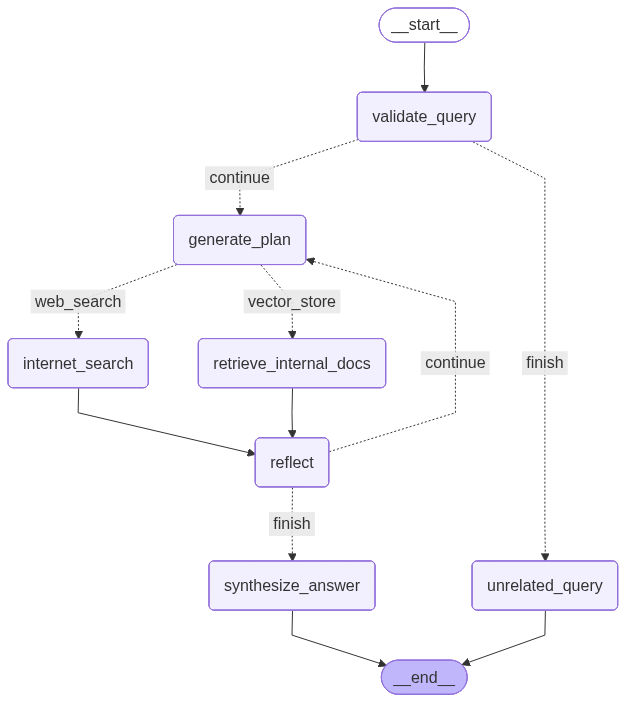

In [ ]:
max_attempts: int = 3
initial_interval: float = 1.0
recursion_limit: int = 50

# Memory
short_term_memory = MemorySaver()
long_term_memory = InMemoryStore()

# Build the graph
builder: StateGraph = StateGraph(State)

builder.add_node(
    "validate_query",
    validate_query_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "unrelated_query",
    unrelated_query_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)

builder.add_node(
    "generate_plan",
    generate_plan_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "retrieve_internal_docs",
    retrieve_internal_docs_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "internet_search",
    internet_search_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "reflect",
    reflection_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)
builder.add_node(
    "synthesize_answer",
    synthesize_answer_node,
    retry_policy=RetryPolicy(
        max_attempts=max_attempts, initial_interval=initial_interval
    ),
)

# Add edges
builder.add_edge(START, "validate_query")
builder.add_conditional_edges(
    "validate_query",
    should_continue_condition,
    {
        NextAction.CONTINUE: "generate_plan",
        NextAction.FINISH: "unrelated_query",
    },
)
builder.add_conditional_edges(
    "generate_plan",
    route_by_tool_condition,  # function to determine which tool to use
    {
        ToolsType.VECTOR_STORE: "retrieve_internal_docs",
        ToolsType.WEB_SEARCH: "internet_search",
    },
)

builder.add_edge("retrieve_internal_docs", "reflect")
builder.add_edge("internet_search", "reflect")
builder.add_conditional_edges(
    "reflect",
    should_continue_condition,  # function to determine next action
    {
        NextAction.CONTINUE: "generate_plan",
        NextAction.FINISH: "synthesize_answer",
    },
)
builder.add_edge("synthesize_answer", END)
builder.add_edge("unrelated_query", END)

# Compile the graph
long_term_memory = InMemoryStore()
graph = builder.compile(checkpointer=short_term_memory, store=long_term_memory)

# Visualize the graph with ASCII fallback
try:
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
except Exception as e:
    console.print(f"[yellow]PNG visualization failed: {e}[/yellow]")
    console.print("[cyan]Displaying ASCII representation instead:[/cyan]\n")
    try:
        print(graph.get_graph(xray=1).draw_ascii())
    except ImportError as ie:
        console.print(f"[red]ASCII visualization also failed: {ie}[/red]")
        console.print("[magenta]Showing basic graph structure:[/magenta]\n")
        graph_obj = graph.get_graph(xray=1)
        console.print(f"Nodes: {[node.id for node in graph_obj.nodes.values()]}")
        console.print(f"Edges: {[(e.source, e.target) for e in graph_obj.edges]}")

In [ ]:
# Memory
short_term_memory = MemorySaver()
long_term_memory = InMemoryStore()

# Re-build the graph
graph = builder.compile(checkpointer=short_term_memory, store=long_term_memory)
user_query: str = "What are the major achievements of Lionel Messi and Cristiano Ronaldo in their international careers?"

config: dict[str, Any] = {
    "recursion_limit": recursion_limit,
    "configurable": {
        "thread_id": "test-01",
        "user_id": "user-123",
    },
}
response = await graph.ainvoke(
    {"question": user_query},
    config=config,
)

🚨 Validating user question against context topics...
--- Evaluating Multi Step Reasoning Policy ---
Number of steps: 3...
⚠️ Number of steps completed: 1 | Num iterations: 1
--- Evaluating Multi Step Reasoning Policy ---
Plan already exists. Skipping plan generation.
⚠️ Number of steps completed: 2 | Num iterations: 1
--- Evaluating Multi Step Reasoning Policy ---
Plan already exists. Skipping plan generation.
⚠️ Number of steps completed: 3 | Num iterations: 1
--- Evaluating Multi Step Reasoning Policy ---


In [97]:
console.print(response["answer"])

Lionel Messi has multiple Ballon d'Or awards and led Argentina to win the FIFA World Cup. Cristiano Ronaldo is 
celebrated for his athleticism, goal-scoring ability, and relentless pursuit of excellence, becoming an icon of 
discipline and ambition.

In [ ]:
# Memory
short_term_memory = MemorySaver()
long_term_memory = InMemoryStore()

# Re-build the graph
graph = builder.compile(checkpointer=short_term_memory, store=long_term_memory)
user_query: str = "What are the major achievements of Lionel Messi and Cristiano Ronaldo in their international careers?"

config: dict[str, Any] = {
    "recursion_limit": recursion_limit,
    "configurable": {
        "thread_id": "test-01",
        "user_id": "user-123",
    },
}
async for chunk in graph.astream(
    {"question": user_query}, config=config, stream_mode="updates"
):
    print(chunk)

🚨 Validating user question against context topics...
--- Evaluating Multi Step Reasoning Policy ---
{'validate_query': {'current_index': -1, 'is_related_to_topics': True, 'step_state': [{'index': -1, 'question': 'What are the major achievements of Lionel Messi and Cristiano Ronaldo in their international careers?', 'rewritten_queries': [], 'summary': "The user's query 'What are the major achievements of Lionel Messi and Cristiano Ronaldo in their international careers?' is not related to the list of allowed query."}], 'plan': None, 'retrieved_documents': []}}
Number of steps: 3...
{'generate_plan': {'current_index': 0, 'is_related_to_topics': True, 'question': 'What are the major achievements of Lionel Messi and Cristiano Ronaldo in their international careers?', 'plan': Plan(steps=[Step(index=1, question='What are the major international achievements of Lionel Messi?', tool=<ToolsType.VECTOR_STORE: 'vector_store'>, keywords='Lionel Messi international achievements', rationale="This st

In [103]:
# Memory
short_term_memory = MemorySaver()
long_term_memory = InMemoryStore()

# Re-build the graph
graph = builder.compile(checkpointer=short_term_memory, store=long_term_memory)
user_query: str = "What are the major achievements of Lionel Messi and Cristiano Ronaldo in their international careers?"

config: dict[str, Any] = {
    "recursion_limit": recursion_limit,
    "configurable": {
        "thread_id": "test-01",
        "user_id": "user-123",
    },
}
async for msg, metadata in graph.astream(
    {"question": user_query}, config=config, stream_mode="messages"
):
    print(f"Message: {msg}\nMetadata: {metadata}\n")

🚨 Validating user question against context topics...
--- Evaluating Multi Step Reasoning Policy ---
Number of steps: 3...
Message: content='Lionel' additional_kwargs={} response_metadata={'model_provider': 'openai'} id='lc_run--e79f6cb8-5d72-489f-bb32-f64d1c396c41'
Metadata: {'thread_id': 'test-01', 'user_id': 'user-123', 'langgraph_step': 3, 'langgraph_node': 'internet_search', 'langgraph_triggers': ('branch:to:internet_search',), 'langgraph_path': ('__pregel_pull', 'internet_search'), 'langgraph_checkpoint_ns': 'internet_search:74f1878d-8146-3972-b0d6-ffb2e3828659', 'checkpoint_ns': 'internet_search:74f1878d-8146-3972-b0d6-ffb2e3828659', 'ls_provider': 'openai', 'ls_model_name': 'google/gemini-2.0-flash-001', 'ls_model_type': 'chat', 'ls_temperature': 0.0, 'ls_method': 'traceable'}

Message: content=" Messi'" additional_kwargs={} response_metadata={'model_provider': 'openai'} id='lc_run--e79f6cb8-5d72-489f-bb32-f64d1c396c41'
Metadata: {'thread_id': 'test-01', 'user_id': 'user-123', '